### Project title
# Development of a Bimodal Biometric Crime Control System using a Modified Neura Network

Bimodal biometric systems represent a strategic evolution in crime control technologies. By leveraging the complementary strengths of face and fingerprint recognition, and harnessing the power of deep learning, these systems offer a robust, reliable, and efficient solution for identity verification in high-stakes security environments.

# Training Strategy
### Dataset Preparation
Biometric Databases: Use comprehensive datasets that include both modalities, ensuring they represent real-world variability.

### Data Augmentation
Augment the training set to simulate variations such as different angles, lighting conditions, and partial occlusions. Techniques may include rotation, scaling, and translation.
Labeling and Ground Truth: Ensure that each sample is correctly labeled to supervise training.

### Training Process
Loss Functions: Use cross-entropy loss for classification tasks, potentially combined with additional regularization terms to prevent overfitting.
Optimization: Experiment with optimizers like Adam or SGD with momentum. Fine-tune learning rates and implement learning rate decay strategies.
Validation: Use a dedicated validation set to monitor model performance and prevent overfitting.

### Evaluation Metrics and Testing
Accuracy: The overall rate of correct identifications.
Receiver Operating Characteristic (ROC) Curve: Used to evaluate the trade-off between true positive rate and false positive rate.
Confusion Matrix: Provides detailed insights into classification errors.

## Import required libraries

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Dataset Preparation

Load and preprocess fingerprint images from the given folder.
Images are read in grayscale, resized, and normalized.

In [3]:
def load_fingerprints(subject_path):
    fingerprints = []
    fp_dir = os.path.join(subject_path, "Fingerprint")
    for fp_file in os.listdir(fp_dir):
        if fp_file.endswith(".BMP"):
            img = cv2.imread(os.path.join(fp_dir, fp_file), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (256, 256))
            img = img / 255.0  # Normalize
            fingerprints.append(img)
    return fingerprints

Load and preprocess face images from the given folder.
Images are read in grayscale, resized, and normalized.

In [6]:
def load_faces(subject_path):
    faces = []
    
    for side in ["left", "right"]:
        eye_dir = os.path.join(subject_path, side)
        for eye_file in os.listdir(eye_dir):
            if eye_file.endswith(".bmp"):
                # Read and preprocess the eye image directly
                eye_img = cv2.cvtColor(cv2.imread(os.path.join(eye_dir, eye_file)), cv2.COLOR_BGR2RGB)
                
                # Resize to match input dimensions of the pretrained model
                eye_img = cv2.resize(eye_img, (224, 224))  # Standard size for MobileNetV2/VGG16
                eye_img = eye_img / 255.0  # Normalize pixel values
                
                faces.append(eye_img)
    return faces

### Organize and match face and fingerprint images.

Iterates through each subject folder in base_path (e.g., '1' to '45'),
loads fingerprint, left face, and right face images, and creates samples.
Each sample consists of one fingerprint image paired with a representative
left and right face image for that subject.

In [9]:
def load_dataset(base_path="Project Assignments/Tumininu Akibowale/IRIS and FINGERPRINT DATASET"):
    X_fingerprint = []
    X_eyes = []
    y = []
    
    for subject_id in range(1, 46):
        subject_path = os.path.join(base_path, str(subject_id))
        
        # Load fingerprints (10 per subject)
        fps = load_fingerprints(subject_path)
        # Load eyes (10 per subject)
        eyes = load_faces(subject_path)
        
        # Ensure equal samples (skip if mismatched)
        min_samples = min(len(fps), len(eyes))
        if min_samples == 0:
            print(f"Skipping subject {subject_id}: No eye/fingerprint data")
            continue
            
        X_fingerprint.extend(fps[:min_samples])
        X_eyes.extend(eyes[:min_samples])
        y.extend([subject_id - 1] * min_samples)  # 0-based labels
    
    # Convert to numpy arrays
    X_fingerprint = np.array(X_fingerprint)
    X_eyes = np.array(X_eyes)
    y = to_categorical(np.array(y), num_classes=45)
    
    return X_fingerprint, X_eyes, y


# Data Modelling

We will create neural network that processes three modalities (left face, right face, and fingerprint), fuses their features, and produces a classification output. Each branch uses a simple convolutional neural network (CNN) that extracts a 128-dimensional feature vector. These three feature vectors are then concatenated into a 384-dimensional vector, which is passed through fully connected layers to generate the final predictions.

In [12]:
def build_fingerprint_model(input_shape=(256, 256, 1)):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

In [14]:
def build_face_model(input_shape=(224, 224, 3)):
    input = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=input, outputs=x)

In [16]:
def build_fusion_model():
    # Input layers
    fingerprint_input = Input(shape=(256, 256, 1))
    face_input = Input(shape=(224, 224, 3))
    
    # Get feature extractors
    fingerprint_features = build_fingerprint_model()(fingerprint_input)
    face_features = build_face_model()(face_input)
    
    # Concatenate features
    combined = Concatenate()([fingerprint_features, face_features])
    
    # Final classification layers
    x = Dense(256, activation='relu')(combined)
    x = Dense(128, activation='relu')(x)
    output = Dense(45, activation='softmax')(x)  # 45 subjects
    
    return Model(inputs=[fingerprint_input, face_input], outputs=output)

# Data Splitting

We create a BimodalBiometricDataset class that converts the preprocessed NumPy arrays (for fingerprint, left face, and right face) into PIL images, applies transforms (including data augmentation for training), and assigns a numerical label to each subject.

In [19]:
# 1. Load data
X_fp, X_eyes, y = load_dataset()

# 2. Add channel dimension to fingerprints
X_fp = np.expand_dims(X_fp, axis=-1)

# 3. Split paired data
X_combined = list(zip(X_fp, X_eyes))
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
X_fp_train, X_eyes_train = zip(*X_train)
X_fp_test, X_eyes_test = zip(*X_test)

# 4. Convert to numpy arrays
X_fp_train = np.array(X_fp_train)
X_eyes_train = np.array(X_eyes_train)
X_fp_test = np.array(X_fp_test)
X_eyes_test = np.array(X_eyes_test)

# 5. Verify
assert len(X_fp_train) == len(X_eyes_train) == len(y_train), "Train set misaligned!"
assert len(X_fp_test) == len(X_eyes_test) == len(y_test), "Test set misaligned!"
print("Data splitting successful!")


Data splitting successful!


# Start the training on the data

In [25]:
# Build and compile model
model = build_fusion_model()
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(
    [X_fp_train, X_eyes_train], y_train,
    validation_data=([X_fp_test, X_eyes_test], y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.0112 - loss: 6.8656 - val_accuracy: 0.0111 - val_loss: 3.8300
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.0267 - loss: 3.8007 - val_accuracy: 0.0333 - val_loss: 3.8157
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.0337 - loss: 3.8024 - val_accuracy: 0.0333 - val_loss: 3.8268
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.0436 - loss: 3.7850 - val_accuracy: 0.0222 - val_loss: 3.8994
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.1021 - loss: 3.6448 - val_accuracy: 0.0667 - val_loss: 3.9549
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.1648 - loss: 3.3132 - val_accuracy: 0.0778 - val_loss: 3.8371
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.2760 - loss: 2.7168 - val_accuracy: 0.1000 - val_loss: 3.9352
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4044 - loss: 2.1596 - val_accuracy: 0.1667 - val_loss:

# Check the performance of the model during training 

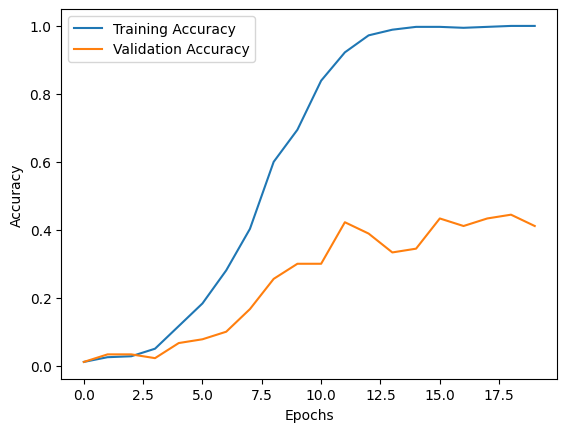

In [27]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the Model

In [29]:
from sklearn.metrics import confusion_matrix

# Predict test set
y_pred = model.predict([X_fp_test, X_eyes_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Calculate FAR & FRR
total_samples = np.sum(cm)
genuine_accepts = np.sum(np.diag(cm))
false_accepts = np.sum(cm) - genuine_accepts
false_rejects = total_samples - genuine_accepts

FAR = false_accepts / total_samples
FRR = false_rejects / total_samples

print(f"False Acceptance Rate (FAR): {FAR:.4f}")
print(f"False Rejection Rate (FRR): {FRR:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step
False Acceptance Rate (FAR): 0.5889
False Rejection Rate (FRR): 0.5889


# Applying Transfer Learning for Bimodal Biometrics

we will use pre-trained 
networks to extract face and fingerprint features, and then train a new classifier on top.

Steps for Transfer Learning
Use a Pretrained Model for Face Recognition and Fingerprint Recognition

    VGG16 for Fingerprint Recognition

    MobileNetV2 for Face Recognition

    Extract fingerprint embeddings.

    Combine Features and Train a Final Classifier

    Train only the last layers, while freezing the backbone models.

## Import Pre-trained model 

In [22]:
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
# import tensorflow_addons as tfa  # For triplet loss

## Build pre-trained model for face recognition

In [25]:
def build_pretrained_face_model():
    base_model = MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False  # Freeze layers
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3)
    ])
    return model

## Build pre-trained model for fingerpring recognition

In [28]:
def build_pretrained_fingerprint_model():
    base_model = VGG16(
        input_shape=(256, 256, 1),
        include_top=False,
        weights=None  # Train from scratch (fingerprint-specific)
    )
    
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3)
    ])
    return model


## Fusion Model for Pretrained Networks

In [31]:
def build_pretrained_fusion_model():
    # Input layers
    fingerprint_input = Input(shape=(256, 256, 1), name="fingerprint_input")
    face_input = Input(shape=(224, 224, 3), name="face_input")
    
    # Pretrained feature extractors
    fingerprint_features = build_pretrained_fingerprint_model()(fingerprint_input)
    face_features = build_pretrained_face_model()(face_input)
    
    # Concatenate features
    combined = Concatenate()([fingerprint_features, face_features])
    
    # Classification head
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.5)(x)
    output = Dense(45, activation='softmax')(x)
    
    return Model(
        inputs=[fingerprint_input, face_input],
        outputs=output,
        name="Bimodal_Pretrained_Model"
    )

## Train with Triplet Loss to improved discrimination

In [34]:
import random

def generate_triplets(X_fp, X_eyes, y, num_triplets=1000):
    anchors = []
    positives = []
    negatives = []
    
    # Get unique subject IDs (0 to 44)
    subject_ids = np.unique(np.argmax(y, axis=1))
    
    for _ in range(num_triplets):
        # Randomly pick an anchor subject
        anchor_subject = random.choice(subject_ids)
        
        # Get all fingerprint and eye indices for this subject
        anchor_mask = (np.argmax(y, axis=1) == anchor_subject)
        anchor_fps = X_fp[anchor_mask]
        anchor_eyes = X_eyes[anchor_mask]
        
        # Randomly pick an anchor and positive pair
        anchor_idx = random.randint(0, len(anchor_fps) - 1)
        positive_idx = random.randint(0, len(anchor_eyes) - 1)
        
        # Pick a negative (eye from a different subject)
        negative_subject = random.choice([s for s in subject_ids if s != anchor_subject])
        negative_mask = (np.argmax(y, axis=1) == negative_subject)
        negative_eyes = X_eyes[negative_mask]
        negative_idx = random.randint(0, len(negative_eyes) - 1)
        
        # Append to lists
        anchors.append(anchor_fps[anchor_idx])
        positives.append(anchor_eyes[positive_idx])
        negatives.append(negative_eyes[negative_idx])
    
    return np.array(anchors), np.array(positives), np.array(negatives)

In [36]:
# Generate triplets
anchors, positives, negatives = generate_triplets(X_fp_train, X_eyes_train, y_train, num_triplets=1000)
print(f"Anchors shape: {anchors.shape}")
print(f"Positives shape: {positives.shape}")
print(f"Negatives shape: {negatives.shape}")

Anchors shape: (1000, 256, 256, 1)
Positives shape: (1000, 224, 224, 3)
Negatives shape: (1000, 224, 224, 3)


## Training & Fine-Tuning

In [38]:
model = build_pretrained_fusion_model()
model.compile(
    optimizer=Adam(0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    [X_fp_train, X_eyes_train], y_train,
    validation_data=([X_fp_test, X_eyes_test], y_test),
    epochs=15,
    batch_size=16
)

Epoch 1/15
23/23 [==============================] - 376s 16s/step - loss: 4.0571 - accuracy: 0.0222 - val_loss: 3.7352 - val_accuracy: 0.0889
Epoch 2/15
23/23 [==============================] - 372s 16s/step - loss: 3.5974 - accuracy: 0.0750 - val_loss: 3.5874 - val_accuracy: 0.1444
Epoch 3/15
23/23 [==============================] - 350s 15s/step - loss: 3.4053 - accuracy: 0.1111 - val_loss: 3.3503 - val_accuracy: 0.2222
Epoch 4/15
23/23 [==============================] - 377s 16s/step - loss: 3.1527 - accuracy: 0.1694 - val_loss: 3.0319 - val_accuracy: 0.3000
Epoch 5/15
23/23 [==============================] - 363s 16s/step - loss: 2.7701 - accuracy: 0.2583 - val_loss: 2.6651 - val_accuracy: 0.4889
Epoch 6/15
23/23 [==============================] - 363s 16s/step - loss: 2.4906 - accuracy: 0.2972 - val_loss: 2.2987 - val_accuracy: 0.5444
Epoch 7/15
23/23 [==============================] - 378s 17s/step - loss: 2.1282 - accuracy: 0.3972 - val_loss: 1.9117 - val_accuracy: 0.6111
Epoch 

## Evaluate Pretrained Model

In [61]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 85.56%


In [63]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true_classes, 
    y_pred_classes, 
    zero_division=0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.33      0.50         3
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           7       1.00      0.12      0.22         8
           8       0.33      1.00      0.50         1
           9       0.67      1.00      0.80         2
          10       1.00      1.00      1.00         1
          11       0.60      1.00      0.75         3
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         1
          17       0.33      1.00      0.50         1
          18       1.00    

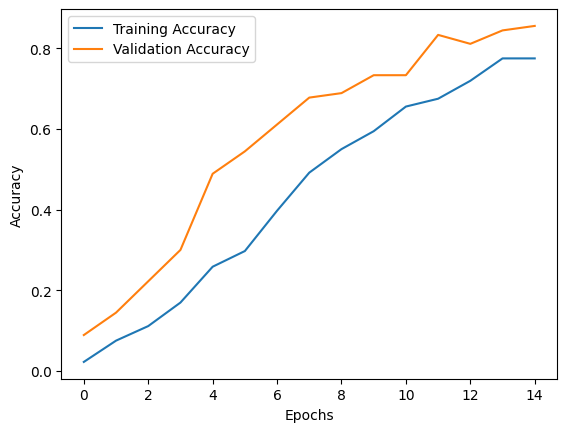

In [83]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()